In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Hiragino Sans"
plt.rcParams["axes.unicode_minus"] = False

📏 距離: 1045.34 m
🛣️ ノード数: 13


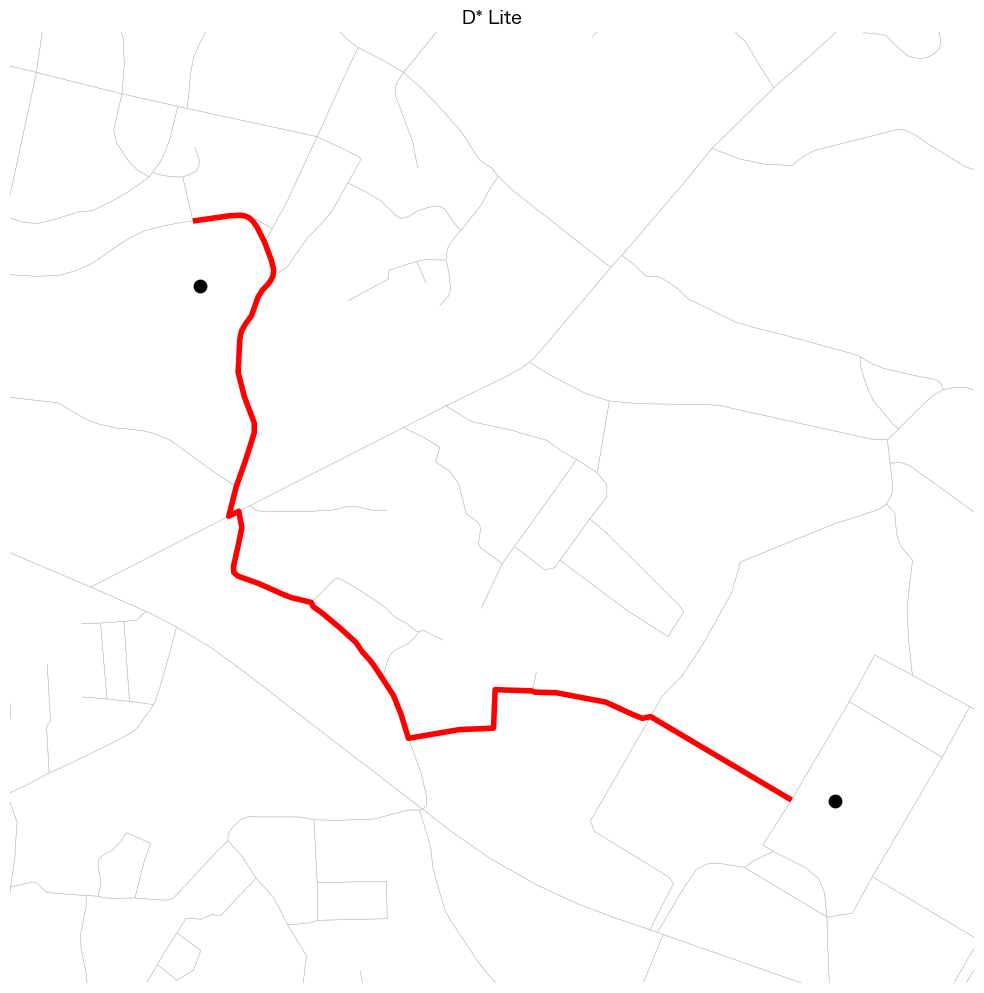

In [ ]:
import sys, os

# ノートブックからプロジェクトのルートを取得
notebook_dir = os.path.dirname(os.path.abspath(__file__)) if "__file__" in globals() else os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(project_root)

# 関数をインポート
from scripts.QGIS.run_main import run_dlite_algorithm

# 実行
result = run_dlite_algorithm()

import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx 
from shapely.geometry import LineString, Point
import os
os.environ["CONTEXTILY_CACHE_DIR"] = "/Users/segawamizuto/QGIS_Project/.cache/contextily"

# --- 経路をGeoDataFrame化（元は緯度経度座標） ---
route_line = LineString(result["route_coords"])
start_pt = Point(result["start"].x, result["start"].y)
goal_pt = Point(result["goal"].x, result["goal"].y)

# --- 背景の道路データ ---
roads = gpd.read_file("/Users/segawamizuto/QGIS_Project/data/processed/roads/ube_roads.shp")

# --- データのCRS確認（なければ設定） ---
if roads.crs is None:
    roads = roads.set_crs(epsg=3857)

# --- 背景地図と整合させるため、すべてをEPSG:3857（Web Mercator）に変換 ---
roads_view = roads.to_crs(epsg=3857)
route_view = gpd.GeoDataFrame(geometry=[route_line], crs=roads.crs).to_crs(epsg=3857)
start_view = gpd.GeoDataFrame(geometry=[start_pt], crs=roads.crs).to_crs(epsg=3857)
goal_view = gpd.GeoDataFrame(geometry=[goal_pt], crs=roads.crs).to_crs(epsg=3857)

# --- プロット ---
fig, ax = plt.subplots(figsize=(10, 10))
roads_view.plot(ax=ax, color="#bbbbbb", linewidth=0.3)
route_view.plot(ax=ax, color="red", linewidth=4)
start_view.plot(ax=ax, color="black", markersize=80)
goal_view.plot(ax=ax, color="black", markersize=80)

# --- 経路周辺だけを拡大 ---
minx, miny, maxx, maxy = route_view.total_bounds
margin = 200
ax.set_xlim(minx - margin, maxx + margin)
ax.set_ylim(miny - margin, maxy + margin)

# --- 背景地図を追加（OpenStreetMap） ---
# ctx.add_basemap(
#     ax,
#     source=ctx.providers.OpenStreetMap.Mapnik,
#     crs=roads_view.crs,
#     zoom=16
# )

plt.title("D* Lite", fontsize=13)
ax.set_axis_off()
plt.tight_layout()
plt.show()

🚫 通行止め設定: 1351032885 ↔ 1351033692
📏 新しい距離: 1294.55 m
🛣️ ノード数: 17


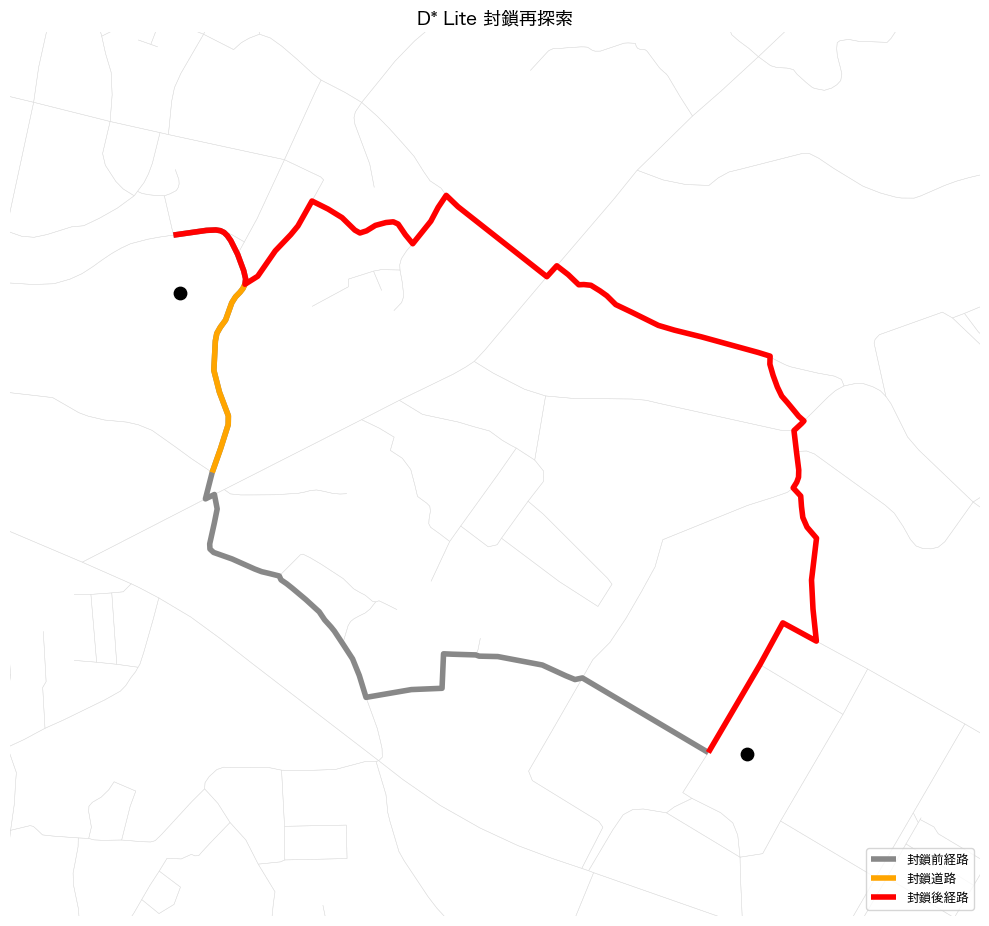

🚫 通行止め設定: 1351033815 ↔ 3509584144
📏 新しい距離: 1334.58 m
🛣️ ノード数: 14


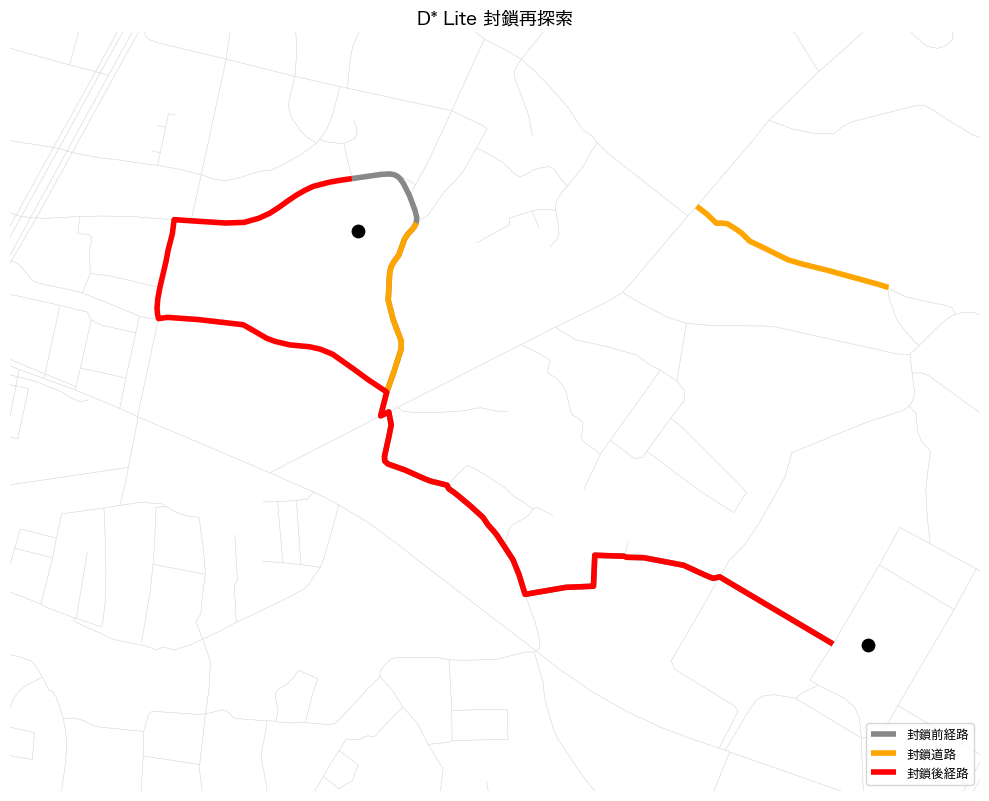

👋 終了します。


In [ ]:
from scripts.QGIS.dlite_algorithm import DStarLite
from scripts.QGIS.run_main import build_route_coords
from shapely.geometry import LineString, Point
from shapely.ops import unary_union
import geopandas as gpd
import contextily as ctx
import os


# --- キャッシュ有効化（高速化） ---
os.environ["CONTEXTILY_CACHE_DIR"] = "/Users/segawamizuto/QGIS_Project/.cache/contextily"

# --- グラフ・初期データ取得 ---
G = result["graph"]
node_positions = result["node_positions"]
edge_geom_map = result["edge_geom_map"]
start_id = result["route_nodes"][0]
goal_id = result["route_nodes"][-1]

dlite = DStarLite(G, start_id, goal_id, node_positions)
dlite.compute_shortest_path()

# --- 経路データ ---
original_route_coords = result["route_coords"]  # 初回ルート保存
closed_edges_list = []

# --- 背景道路データ ---
roads = gpd.read_file("/Users/segawamizuto/QGIS_Project/data/processed/roads/ube_roads.shp")
roads_view = roads.to_crs(epsg=3857)

# --- 可視化関数（毎回更新） ---
def plot_routes(old_coords, new_coords, closed_edges_list):
    # --- GeoDataFrame化 ---
    new_route_line = LineString(new_coords)
    old_route_line = LineString(old_coords)

    new_route_view = gpd.GeoDataFrame(geometry=[new_route_line], crs=roads.crs).to_crs(epsg=3857)
    old_route_view = gpd.GeoDataFrame(geometry=[old_route_line], crs=roads.crs).to_crs(epsg=3857)

    # --- 封鎖道路（GeoDataFrame化） ---
    closed_lines = []
    for u, v in closed_edges_list:
        geom = edge_geom_map.get((u, v))
        if geom:
            closed_lines.append(LineString(geom))
    closed_view = gpd.GeoDataFrame(geometry=closed_lines, crs=roads.crs).to_crs(epsg=3857)

    # --- 開始・終了 ---
    start_pt = Point(result["start"].x, result["start"].y)
    goal_pt = Point(result["goal"].x, result["goal"].y)
    start_view = gpd.GeoDataFrame(geometry=[start_pt], crs=roads.crs).to_crs(epsg=3857)
    goal_view = gpd.GeoDataFrame(geometry=[goal_pt], crs=roads.crs).to_crs(epsg=3857)

    # --- プロット ---
    fig, ax = plt.subplots(figsize=(10, 10))
    roads_view.plot(ax=ax, color="#dddddd", linewidth=0.3)

    # --- 封鎖前ルートを封鎖部分除外して描画 ---
    if not closed_view.empty:
        closed_union = unary_union(closed_view.geometry)
        old_route_trimmed = old_route_line.difference(closed_union)
        old_route_view = gpd.GeoDataFrame(geometry=[old_route_trimmed], crs=roads.crs).to_crs(epsg=3857)
        old_route_view.plot(ax=ax, color="#888888", linewidth=4, label="封鎖前経路")
    else:
        old_route_view.plot(ax=ax, color="#888888", linewidth=4, label="封鎖前経路")

    # --- 封鎖道路（オレンジ） ---
    if not closed_view.empty:
        closed_view.plot(ax=ax, color="orange", linewidth=4, label="封鎖道路")

    # --- 新ルート（赤） ---
    new_route_view.plot(ax=ax, color="red", linewidth=4, label="封鎖後経路")

    # --- 開始・終了 ---
    start_view.plot(ax=ax, color="black", markersize=80)
    goal_view.plot(ax=ax, color="black", markersize=80)

    # --- 拡大範囲 ---
    minx, miny, maxx, maxy = new_route_view.total_bounds
    margin = 200
    ax.set_xlim(minx - margin, maxx + margin)
    ax.set_ylim(miny - margin, maxy + margin)

    # --- 背景地図（必要ならコメント解除） ---
    # ctx.add_basemap(
        # ax,
        # source=ctx.providers.OpenStreetMap.Mapnik,
        # crs=roads_view.crs,
        # zoom=16)

    plt.title("D* Lite 封鎖再探索", fontsize=13)
    ax.set_axis_off()
    plt.legend(loc="lower right", fontsize=9)
    plt.tight_layout()
    plt.show()


# --- 封鎖入力ループ ---
while True:
    cmd = input("🚧 封鎖する道路を指定 (u v) / qで終了").strip().lower()
    if cmd == "q":
        print("👋 終了します。")
        break

    try:
        u, v = map(int, cmd.split())
    except ValueError:
        print("⚠️ 'u v' の形式で入力してください（例：101 102）")
        continue

    if not G.has_edge(u, v):
        print("⚠️ その道路は存在しません")
        continue

    # --- 通行止め設定 ---
    G[u][v]["weight"] = float("inf")
    if G.has_edge(v, u):
        G[v][u]["weight"] = float("inf")

    closed_edges_list.append((u, v))
    print(f"🚫 通行止め設定: {u} ↔ {v}")

    # --- 経路再計算 ---
    dlite.update_vertex(u)
    dlite.update_vertex(v)
    dlite.compute_shortest_path()

    new_path = dlite.extract_path()
    if not new_path:
        print("❌ 経路が見つかりませんでした")
        continue

    route_coords = build_route_coords(new_path, edge_geom_map)
    result["route_nodes"] = new_path
    result["route_coords"] = route_coords
    result["distance_m"] = sum(
        G[new_path[i]][new_path[i + 1]]["weight"]
        for i in range(len(new_path) - 1)
        if G.has_edge(new_path[i], new_path[i + 1])
    )

    print(f"📏 新しい距離: {result['distance_m']:.2f} m")
    print(f"🛣️ ノード数: {len(new_path)}")

    # --- 即描画 ---
    plot_routes(original_route_coords, route_coords, closed_edges_list)

    # 今回のルートを「次回の旧ルート」として保存
    original_route_coords = route_coords